Importing libraries

In [4]:
import pandas as pd 
import pickle 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [5]:
import mlflow 


mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment('taxi-experiment')

2023/05/30 16:20:59 INFO mlflow.tracking.fluent: Experiment with name 'taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///c:/Users/Pizzu/mlops_zoomcamp2023/Module2.Experiment tracking and '
 'model management/mlruns/1'), creation_time=1685452859649, experiment_id='1', last_update_time=1685452859649, lifecycle_stage='active', name='taxi-experiment', tags={}>

Downloading and preparing data 

In [6]:
def read_dataframe(filename):

    df = pd.read_parquet(filename)
    df['compare'] = df.tpep_dropoff_datetime > df.tpep_pickup_datetime
    df = df.query('compare == True').iloc[:,:19]

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # set duration between 1 and 60 becase it's make sense from taxi bussines perspective
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('C:/Users/Pizzu/mlops_zoomcamp2023/data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('C:/Users/Pizzu/mlops_zoomcamp2023/data/yellow_tripdata_2022-01.parquet')

In [8]:
len(df_train), len(df_val)

(2421440, 2421440)

In [9]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [10]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.0014961794257164

c:\Users\Pizzu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\Pizzu\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


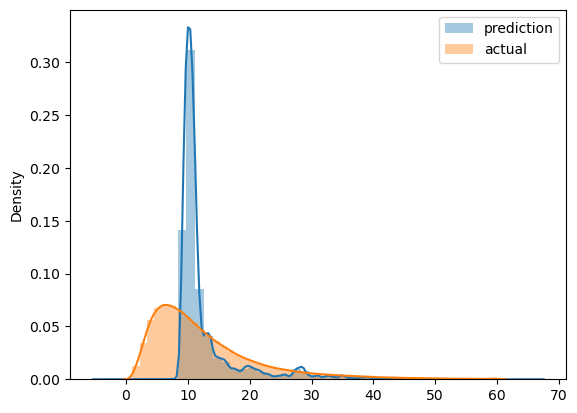

In [12]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [13]:
with open('C:/Users/Pizzu/mlops_zoomcamp2023/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.0014961794257164

In [39]:
with mlflow.start_run():
    
    mlflow.set_tag('developer', 'timur')
    
    mlflow.log_param('train-data-path','C:/Users/Pizzu/mlops_zoomcamp2023/data/yellow_tripdata_2022-01.parquet')
    mlflow.log_param('valid-data-path','C:/Users/Pizzu/mlops_zoomcamp2023/data/yellow_tripdata_2022-02.parquet')
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

    mlflow.log_artifact(local_path='C:/Users/Pizzu/mlops_zoomcamp2023/models/lin_reg.bin', artifact_path='models_pickle')

In [20]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [25]:
train = xgb.DMatrix(X_train, label = y_train)
valid = xgb.DMatrix(X_val, label = y_val)

In [27]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [28]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[17:00:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.90992                          
[1]	validation-rmse:11.06852                          
[2]	validation-rmse:9.55271                           
[3]	validation-rmse:8.31399                           
[4]	validation-rmse:7.30946                           
[5]	validation-rmse:6.50406                           
[6]	validation-rmse:5.86521                           
[7]	validation-rmse:5.36478                           
[8]	validation-rmse:4.97796                           
[9]	validation-rmse:4.68264                           
[10]	validation-rmse:4.45751                          
[11]	validation-rmse:4.28979                          
[12]	validation-rmse:4.16442                          
[13]	validation-rmse:4.07172                          

KeyboardInterrupt: 

In [37]:
params = {
    'earning_rate': 0.15943654959673612,
    'max_depth': 41,
    'min_child_weight': 7.387705850109999,
    'objective': 'reg: linear',
    'reg_alpha': 0.08057129193245657,
    'reg_lambda': 0.003056121017620033,
    'seed': 42
}

mlflow.xgboost.autolog()

booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
)

2023/05/30 18:07:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'edb843b2e4734b2baabb1bd020c8ff9a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


XGBoostError: [18:07:49] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\objective.cc:26: Unknown objective function: `reg: linear`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror
